Predicting Wine Quality Based on Main features with Main Features
====================================


# Step0 - Preparing Necesarray Packages and Dataset

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
wine = pd.read_csv('winequality_red.csv', sep = ';')

In [22]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [27]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## (1) Converting quality value into binary data

When it comes to predicting wine quality as dependent variable, its data type is going to be changed into dummy variable. This is because when people taste wine, they don't give numbers or figures for wine quality in usual cases. They rather just feel this wine is good or bad. Starting from this point, the quality is going to be transformed in dummy variable as follows. 

In [23]:
bins = (2, 6.5, 8)
group_name = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_name)

0    1382
1     217
Name: quality, dtype: int64


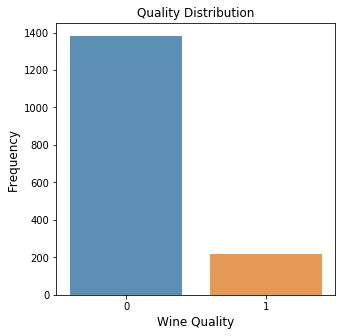

In [24]:
label_quality = LabelEncoder()
wine['quality'] = label_quality.fit_transform(wine['quality'])
print(wine['quality'].value_counts())

dv = wine['quality'].value_counts()
plt.figure(figsize=(5,5))
sns.barplot(dv.index, dv.values, alpha=0.8)
plt.title('Quality Distribution')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Wine Quality', fontsize=12)
plt.show();

It is possible to see that 0(bad quality) result was much more frequent than 1(good quality). There were 1382 numbers of bad quality cases and 217 numbers of good quality cases. The next stage is to prepare train and test data sets.

## (2) Preparing Training and Test Data

In [25]:
x = wine.drop('quality', axis = 1)
y = wine['quality']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
                                                    random_state = 42 )

### (2) - 1 Normalizing Variables' Scale

Before moving onto analysis step, it is essential to normalize varible's scale. If normalization is skipped, it is highly possilbe that various statistic problem would occur such as overfitting. Therefore, all the variables would be adjusted so that their scale would fit in the range of 0 to 1. 

In [26]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

-----------------------------------------------------

# Step 1 - Conducting Simple Analysis without Setting Parameter

In [88]:
basic_models = [GaussianNB(), LogisticRegression(), SVC(), 
                tree.DecisionTreeClassifier(), RandomForestClassifier(n_estimators=200),
               KNeighborsClassifier(5)]
model_list = ['bayes_model', 'logit', 'svm', 'decision_tree','random_forest', 'knn']

simple_test_result =  []

for i in basic_models:
    train = i.fit(x_train, y_train)
    prediction = i.predict(x_test)
    simple_test_result.append(metrics.accuracy_score(y_test,prediction))
    
result_table = pd.DataFrame(simple_test_result, columns = ['accuracy score'], index = model_list)

result_table.sort_values(by = ['accuracy score'], ascending = False, inplace = True)
print(result_table)

               accuracy score
random_forest        0.896875
knn                  0.881250
svm                  0.875000
decision_tree        0.871875
logit                0.865625
bayes_model          0.846875


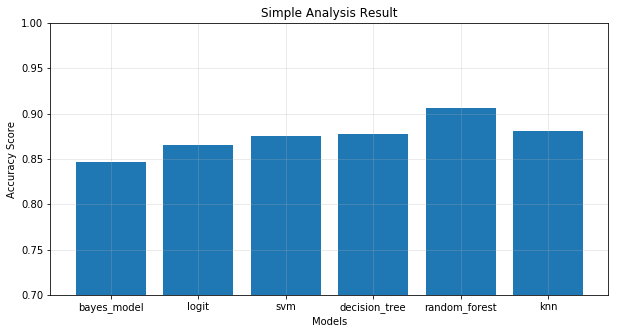

In [87]:
plt.figure(figsize = (10,5))
plt.bar(model_list, simple_test_result)
plt.title('Simple Analysis Result')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.ylim(0.7, 1)
plt.grid(alpha = 0.3);

## Analysis Report

It seems that random forest model is the most suitable model when it comes to predicting wine quality, whose accuracy score is about 0.89. This means that random forest model could predict wine quality with 89% accuracy. However, ** *there are two drawbacks* ** of this simple result. First this result is somewhat skeptical because any of hyper parameters are not manipulated, leaving possibility that there would be better classification model. Second, when it comes to randome forest model, which is essenble method of multiple decision tree, prediction result is not stable. The figure could increase or decrease whenever models are used. This unstable prediction result could not be used in actual prediction model.

In order to solve these two drawbacks, it is essential to specify the best parameter condition of each model. From now on, main focus is to use grid search package from sklearn so that we could know detail parameter conditions. 

-----------------------------------



# Step2 - Searching Optimal Model Parameter

## 1)Decision Tree

In [28]:
param_grid = {'criterion':['gini', 'entropy'],
              'min_samples_leaf':[1, 2, 3, 4],
              'random_state':[14]}

tree = GridSearchCV(DecisionTreeClassifier(), param_grid)

tree.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4], 'random_state': [14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
tree.best_params_

{'criterion': 'gini', 'min_samples_leaf': 4, 'random_state': 14}

In [30]:
tree_prediction = tree.predict(x_test)
print(metrics.accuracy_score(y_test,tree_prediction))

0.884375


### Analysis Report of Decision Tree Model

In this case, finding optimal parameters actually reported lower rate of prediction performance. Through grid search, accuracy score is 0.884475. Let's compare this result with a result of simple analysis version. For the reminder and getting specifc parameters, detail information would be as follows about simple analysis.

In [52]:
tree_model = DecisionTreeClassifier()

In [53]:
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
predict = tree_model.predict(x_test)
metrics.accuracy_score(y_test, predict)

0.8875

In [55]:
tree_model.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

The prediction level for simple analysis model is 0.887, which is 0.003 higher than grid searched model. So, in this case, it is rational to follow model's default parameter as suggested in above. 

-----------------------------------

## 2) Random Forest

In [32]:
rfc=RandomForestClassifier(n_jobs = -1, random_state=42)

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

In [33]:
rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rfc.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
rfc.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 200}

In [47]:
rfc_prediction=rfc.predict(x_test)

In [48]:
metrics.accuracy_score(y_test,rfc_prediction)

0.9

### Analysis Report of Random Forest

Based on the grid search of random forest, the final prediction level was 0.9, which means that the model could predict wine quality with 90% of accuracy. By comparing the result from the simple analysis, the figure increased by 0.01. This prediction level is higher than decision tree model, guessing that random forest is a essemble method of classifier model. So until now, random forest is the most suitable model for wine quality data. 

-----------------------------------

## 3) Supportive Vector Machine(SVM)

In [49]:
svm = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4],
              'gamma': (1,2,3,'auto'),'decision_function_shape':('ovo','ovr'),
              'shrinking':(True,False)}
clf_svm = GridSearchCV(svm, param_grid = parameters, scoring='accuracy')
clf_svm.fit(x_train,y_train)



GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4], 'gamma': (1, 2, 3, 'auto'), 'decision_function_shape': ('ovo', 'ovr'), 'shrinking': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [50]:
clf_svm.best_params_

{'C': 1.2,
 'decision_function_shape': 'ovo',
 'gamma': 1,
 'kernel': 'rbf',
 'shrinking': True}

In [51]:
svm_prediction = clf_svm.predict(x_test)
print(metrics.accuracy_score(y_test,svm_prediction))

0.9


### Analysis Report of SVM

Through grid searched parameters, it was possible to enhance accuracy score of prediction. Before revising parameters, accuracy score was 0.875 and this same figure increased about 0.125. This number means that SVM model could predict wine quality with 90% of accuracy. Until now, random forest and svm came on to the top in terms of accurately predicting wine quality data.

-----------------------------------

### 4) KNN

In [52]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors':[4,5,6,7],
              'leaf_size':[1,3,5],
              'n_jobs':[-1]}

#Fit the model
knn_model = GridSearchCV(knn, param_grid=param_grid)
knn_model.fit(x_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [4, 5, 6, 7], 'leaf_size': [1, 3, 5], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
knn_model.best_params_

{'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 4}

In [54]:
knn_prediction = knn_model.predict(x_test)
print(metrics.accuracy_score(y_test,knn_prediction))

0.88125


### Analysis Report of KNN

The result of grid search is as same as default analysis. Both accuarcy score is reported as 0.88125. However important point here is not whether whose score is higher, but rather both model's socres are lower than SVM and random forest. So it is rational to neglect KNN model for this particular dataset.

-----------------------------------------------------------------------------------

### 5) Logistic Regression

In [55]:
grid={"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
      "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_model =GridSearchCV(logreg,grid,cv=10)
logreg_model.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
logreg_model.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [57]:
best_logreg = LogisticRegression(penalty='l2', C=1.0)
best_logreg_model = best_logreg.fit(x_train, y_train)
logit_prediction = best_logreg_model.predict(x_test)
print(metrics.accuracy_score(y_test,logit_prediction))

0.865625


### Analysis Report of Logistic Regression

Logistic regression's accuarcy score is also the same case with KNN. Both score of before grid search and after grid search is identical as 0.865625. As a result, the figure is lower than other model's prediction performance, it is natural to ignore the model for the dataset.

-----------------------------------

## 6) Naive Bayes Model

In [58]:
bayes = GaussianNB()
bayes_model = bayes.fit(x_train, y_train)
bayes_prediction = bayes_model.predict(x_test)
print(metrics.accuracy_score(y_test, bayes_prediction))

0.846875


### Analysis Report of Naive Bayes Model

Since Naive Bayes model does not have any hyperparameters to adjust, all conditions were set as default, which is same as simple analysis version. Main point is that its accuracy score is the lowest among other models. As a consequence, it is reasonable to ignore this model for this dataset.

-----------------------------------------------

# Step 3 - Report Summary

In [59]:
tree_score = metrics.accuracy_score(y_test,tree_prediction)
rfc_score = metrics.accuracy_score(y_test,rfc_prediction)
svm_score = metrics.accuracy_score(y_test,svm_prediction)
knn_score = metrics.accuracy_score(y_test,knn_prediction)
logit_score = metrics.accuracy_score(y_test,logit_prediction)
bayes_score = metrics.accuracy_score(y_test, bayes_prediction)

In [71]:
model_list = ['bayes_model', 'logit', 'svm', 'decision_tree','random_forest', 'knn']
test_result =  [metrics.accuracy_score(y_test, bayes_prediction), metrics.accuracy_score(y_test,logit_prediction), metrics.accuracy_score(y_test,svm_prediction),
                metrics.accuracy_score(y_test,tree_prediction), metrics.accuracy_score(y_test,rfc_prediction), metrics.accuracy_score(y_test,knn_prediction)]

result = pd.DataFrame(test_result, index = model_list, columns = ['accuracy score'])
result.sort_values(by = ['accuracy score'], ascending = False, inplace = True)

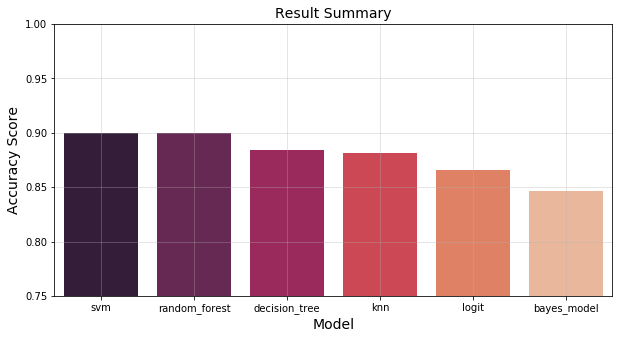

In [86]:
plt.figure(figsize=(10,5))
sns.barplot(x=result.index, y='accuracy score', data=result, palette = 'rocket')
plt.title('Result Summary', fontsize = 14)
plt.xlabel('Model', fontsize = 14)
plt.ylabel('Accuracy Score', fontsize = 14)
plt.ylim(0.75, 1)
plt.grid(alpha = 0.4)

### **Point Summary**

When it comes to predicting red wine quality, 6 machine learning models in total were considered as in the bar plot. Through thorough research about optimal parameters of each model, there were two ideal models for this dataset, which are supportive vector machine and random forest. Both models prediction accuracy score were 0.9 while other models reported significantly lower level of same index. As a result, regarding predicting wine quality, it is going to be beneficial to rely on SVM and random forest. 